In [1]:
import os, statistics, textwrap, glob, json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from collections import Counter
import seaborn as sns
import random
from scipy.stats import ttest_ind

In [2]:
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

In [3]:
def compute_distinct1_corpus(messages):
    """
    Given an iterable of text strings, returns the global Distinct‑1
    (unique unigrams / total unigrams) over the entire corpus.
    """
    tokens = []
    for text in messages:
        if not text:
            continue
        tokens.extend(text.lower().split())
    total = len(tokens)
    return (len(set(tokens)) / total) if total > 0 else 0

def process_json_folder(folder_path):
    """
    Loops over every .json in `folder_path`, computes and stores each file's
    Distinct‑1 for assistant & user, then returns:
      - file_scores: { filename: {'assistant':…, 'user':…}, … }
      - avg_scores:  {'assistant': avg_assistant, 'user': avg_user}
    """
    file_scores     = {}
    assistant_list  = []
    user_list       = []

    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(".json"):
            continue

        fullpath = os.path.join(folder_path, fname)
        with open(fullpath, encoding="utf-8") as f:
            data = json.load(f)

        # extract texts by role
        assistant_texts = [item["content"]
                           for item in data
                           if item.get("role") == "assistant"]
        user_texts      = [item["content"]
                           for item in data
                           if item.get("role") == "user"]

        a_score = compute_distinct1_corpus(assistant_texts)
        u_score = compute_distinct1_corpus(user_texts)

        file_scores[fname] = {"assistant": a_score, "user": u_score}
        assistant_list.append(a_score)
        user_list.append(u_score)

    avg_scores = {
        "assistant": statistics.fmean(assistant_list) if assistant_list else 0,
        "user":      statistics.fmean(user_list)      if user_list     else 0
    }

    return file_scores, avg_scores

Distinct‑1 per file:
  DM_20250427-101833_Interview.json: assistant=0.3154, user=0.4205
  DM_20250428-041223_Interview.json: assistant=0.1084, user=0.1152
  DM_20250426-174355_Interview.json: assistant=0.3311, user=0.4897
  DM_20250426-223017_Interview.json: assistant=0.3499, user=0.4681
  DM_20250426-161454_Interview.json: assistant=0.2628, user=0.4298
  DM_20250427-144510_Interview.json: assistant=0.3487, user=0.4683
  DM_20250427-055904_Interview.json: assistant=0.2976, user=0.3810
  DM_20250427-221558_Interview.json: assistant=0.3293, user=0.4081
  DM_20250427-175121_Interview.json: assistant=0.2410, user=0.3204
  DM_20250427-235930_Interview.json: assistant=0.2501, user=0.3958
  DM_20250426-085818_Interview.json: assistant=0.5296, user=0.8413
  DM_20250427-203136_Interview.json: assistant=0.2826, user=0.3371
  DM_20250427-092438_Interview.json: assistant=0.3003, user=0.1524
  DM_20250428-031608_Interview.json: assistant=0.3335, user=0.4099
  DM_20250426-191205_Interview.json: assi

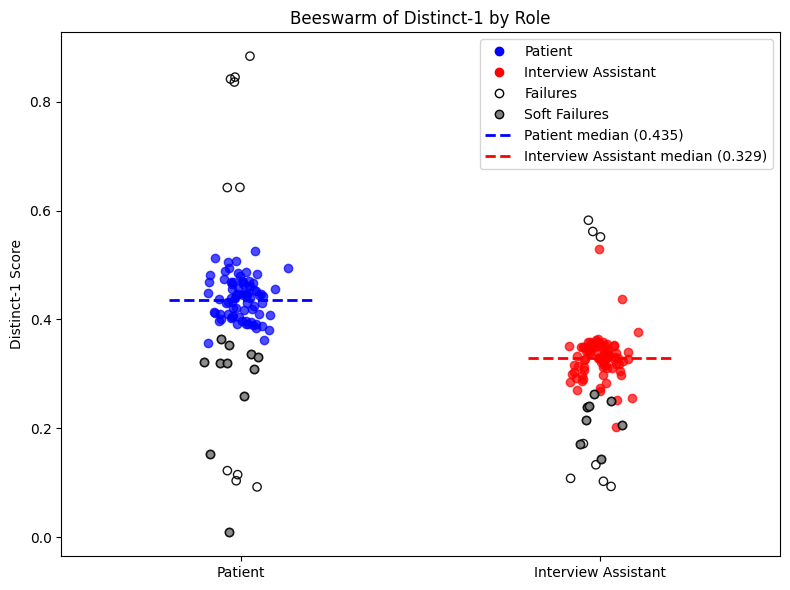

Saved plot to plots/distinct1_lineplot.png


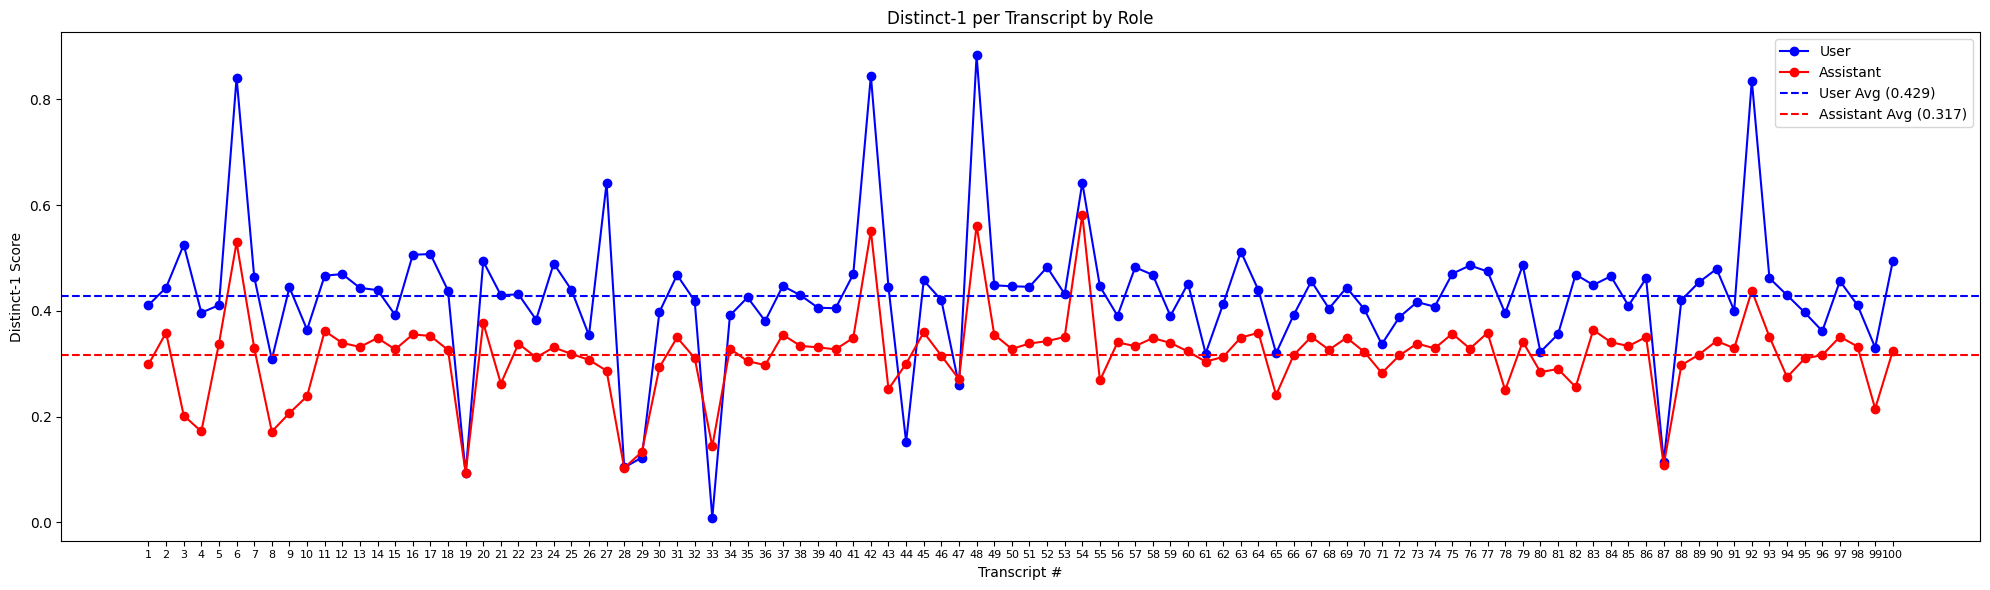

User inliers (n=79): [0.4110576923076923, 0.4442361761949391, 0.5252747252747253, 0.3967828418230563, 0.4109681787406906, 0.4644268774703557, 0.44454628780934924, 0.46673706441393875, 0.46979166666666666, 0.44362969752520626, 0.43944353518821605, 0.392328398384926, 0.506265664160401, 0.5077105575326216, 0.4384976525821596, 0.4938684503901895, 0.4298245614035088, 0.4314789687924016, 0.38348271446862997, 0.4897400820793434, 0.4401064773735581, 0.3981244671781756, 0.46810933940774485, 0.41899441340782123, 0.39147286821705424, 0.4256535947712418, 0.38104089219330856, 0.4473007712082262, 0.42978395061728397, 0.4060810810810811, 0.4051851851851852, 0.46940822467402205, 0.44495412844036697, 0.4577226606538895, 0.4204809930178433, 0.448501872659176, 0.44675090252707583, 0.44570837642192346, 0.4827188940092166, 0.43202979515828677, 0.44644644644644643, 0.3908205841446453, 0.4825765575501584, 0.46825396825396826, 0.3906474820143885, 0.45187165775401067, 0.41362530413625304, 0.5121602288984263, 0

In [4]:
if __name__ == "__main__":
    folder = "25_24_Transcripts"
    per_file, averages = process_json_folder(folder)

    print("Distinct‑1 per file:")
    for fn, scores in per_file.items():
        print(f"  {fn}: assistant={scores['assistant']:.4f}, user={scores['user']:.4f}")

    print("\nAverage Distinct‑1 across all files:")
    print(f"  assistant: {averages['assistant']:.4f}")
    print(f"  user:      {averages['user']:.4f}")

    # Collect scores
    filenames         = sorted(per_file.keys())
    assistant_scores  = [per_file[f]['assistant'] for f in filenames]
    user_scores       = [per_file[f]['user']      for f in filenames]

    pos_user, pos_assist = 1, 2
    fig, ax = plt.subplots(figsize=(8, 6))

    # 3) Split inliers vs outliers by score
    user_inliers  = [s for s in user_scores      if 0.2 <= s <= 0.55]
    user_outliers = [s for s in user_scores      if s < 0.2  or s > 0.55]
    as_inliers    = [s for s in assistant_scores if 0.2 <= s <= 0.55]
    as_outliers   = [s for s in assistant_scores if s < 0.2  or s > 0.55]

    manual_asst_idxs = [7,8,9,32,64,98,20,77]     # zero-based indices into assistant_scores
    manual_user_idxs = [7,9,32,64,70,98,25,43,46,60,79]   # zero-based indices into user_scores

    
    
    # 1) Plot User (non-manual)  
    for idx, score in enumerate(user_scores):
        if idx in manual_user_idxs:
            continue      # skip manual here
        x_j = random.gauss(pos_user, 0.04)
        if score < 0.2 or score > 0.55:
            fc, ec, alpha = 'none', 'black', 0.9
        else:
            fc, ec, alpha = 'blue', 'blue', 0.7
        ax.scatter(x_j, score,
                   facecolors=fc,
                   edgecolors=ec,
                   linewidths=1.0,
                   alpha=alpha,
                   zorder=1,
                   label='_nolegend_')

    # 2) Plot Assistant (non-manual)
    for idx, score in enumerate(assistant_scores):
        if idx in manual_asst_idxs:
            continue
        x_j = random.gauss(pos_assist, 0.04)
        if score < 0.2 or score > 0.55:
            fc, ec, alpha = 'none', 'black', 0.9
        else:
            fc, ec, alpha = 'red', 'red', 0.7
        ax.scatter(x_j, score,
                   facecolors=fc,
                   edgecolors=ec,
                   linewidths=1.0,
                   alpha=alpha,
                   zorder=1,
                   label='_nolegend_')

    # 3) Plot Manual highlights last (always on top)
    for idx in manual_user_idxs:
        x_j = random.gauss(pos_user, 0.04)
        y   = user_scores[idx]
        ax.scatter(x_j, y,
                   facecolors='gray',
                   edgecolors='black',
                   linewidths=1.2,
                   alpha=0.9,
                   zorder=3,
                   label='_nolegend_')
    for idx in manual_asst_idxs:
        x_j = random.gauss(pos_assist, 0.04)
        y   = assistant_scores[idx]
        ax.scatter(x_j, y,
                   facecolors='gray',
                   edgecolors='black',
                   linewidths=1.2,
                   alpha=0.9,
                   zorder=3,
                   label='_nolegend_')


    # 5) Draw median lines
    med_user      = statistics.median(user_scores)
    med_assist    = statistics.median(assistant_scores)
    ax.hlines(
        med_user, pos_user-0.2, pos_user+0.2,
        colors='blue',    linestyles='--', linewidth=2,
        label=f'User median ({med_user:.3f})'
    )
    ax.hlines(
        med_assist, pos_assist-0.2, pos_assist+0.2,
        colors='red',     linestyles='--', linewidth=2,
        label=f'Assistant median ({med_assist:.3f})'
    )

    # — Build custom legend handles —
    legend_elements = [
        # Inliers
        Line2D([0], [0],
               marker='o', linestyle='None',
               markerfacecolor='blue', markeredgecolor='blue',
               label='Patient'),
        Line2D([0], [0],
               marker='o', linestyle='None',
               markerfacecolor='red', markeredgecolor='red',
               label='Interview Assistant'),
        # Outliers
        Line2D([0], [0],
               marker='o', linestyle='None',
               markerfacecolor='none', markeredgecolor='black',
               label='Failures'),
        # Manual highlights
        Line2D([0], [0],
               marker='o', linestyle='None',
               markerfacecolor='gray', markeredgecolor='black',
               label='Soft Failures'),
        # Median lines
        Line2D([0], [0],
               linestyle='--', color='blue', linewidth=2,
               label=f'Patient median ({med_user:.3f})'),
        Line2D([0], [0],
               linestyle='--', color='red',  linewidth=2,
                label=f'Interview Assistant median ({med_assist:.3f})'),
    ]

    # 6) Final formatting
    ax.set_xticks([pos_user, pos_assist])
    ax.set_xticklabels(['Patient', 'Interview Assistant'])
    ax.set_ylabel('Distinct-1 Score')
    ax.set_title('Beeswarm of Distinct-1 by Role')
    ax.set_xlim(0.5, 2.5)
    ax.legend(handles=legend_elements, loc='best')
    plt.tight_layout()

    # 7) Save & show
    output_dir = "plots"
    os.makedirs(output_dir, exist_ok=True)
    plot_path = os.path.join(output_dir, 'distinct1_beeswarm.png')
    plt.savefig(plot_path)
    print(f"Saved beeswarm to {plot_path}")
    plt.show()

    
    
    # 2) Plot scores (make sure this is indented under the if-block)
    filenames = sorted(per_file.keys())
    assistant_scores = [per_file[f]['assistant'] for f in filenames]
    user_scores      = [per_file[f]['user']      for f in filenames]
    x = range(len(filenames))
    avg_assistant = averages['assistant']
    avg_user      = averages['user']

    # Dynamically size figure
    num_ticks      = len(filenames)
    fig_width      = max(10, num_ticks * 0.2)
    plt.figure(figsize=(fig_width, 6))
    
    plt.plot(x, user_scores,      marker='o', linestyle='-', label='User',      color='blue')
    plt.plot(x, assistant_scores, marker='o', linestyle='-', label='Assistant', color='red')
    plt.axhline(avg_user,      linestyle='--', color='blue', label=f'User Avg ({avg_user:.3f})')
    plt.axhline(avg_assistant, linestyle='--', color='red',  label=f'Assistant Avg ({avg_assistant:.3f})')
    # Every tick, rotated and readable
    plt.xticks(
        x,
        [i+1 for i in x],
        fontsize=8
    )
    # plt.subplots_adjust(bottom=0.25)
    plt.xlabel('Transcript #')  
    plt.ylabel('Distinct-1 Score')
    plt.title('Distinct-1 per Transcript by Role')
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(output_dir, 'distinct1_lineplot.png')
    plt.savefig(plot_path)
    print(f"Saved plot to {plot_path}")
    plt.show()

    # 1) Build inlier lists, excluding the manual indices
    user_inliers = [
        score
        for idx, score in enumerate(user_scores)
        if 0.2 <= score <= 0.55 and idx not in manual_user_idxs
    ]
    assistant_inliers = [
        score
        for idx, score in enumerate(assistant_scores)
        if 0.2 <= score <= 0.55 and idx not in manual_asst_idxs
    ]

    # 2) Run an independent-samples t-test (Welch’s by default)
    t_stat, p_val = ttest_ind(user_inliers, assistant_inliers, equal_var=False)

    # 3) Report
    print(f"User inliers (n={len(user_inliers)}): {user_inliers}")
    print(f"Assistant inliers (n={len(assistant_inliers)}): {assistant_inliers}")
    print(f"T-statistic =", t_stat, "p-value =", p_val)

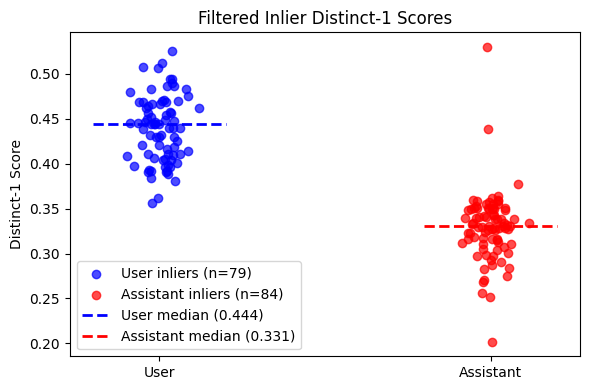

In [5]:
# --- Plot only the filtered inliers ---
pos_user, pos_assist = 1, 2
fig, ax = plt.subplots(figsize=(6, 4))

# Jitter & scatter User inliers (blue)
x_user = [random.gauss(pos_user, 0.04) for _ in user_inliers]
ax.scatter(x_user, user_inliers,
           color='blue', alpha=0.7,
           label=f'User inliers (n={len(user_inliers)})')

# Jitter & scatter Assistant inliers (red)
x_asst = [random.gauss(pos_assist, 0.04) for _ in assistant_inliers]
ax.scatter(x_asst, assistant_inliers,
           color='red', alpha=0.7,
           label=f'Assistant inliers (n={len(assistant_inliers)})')

# Median lines (optional)
med_user  = statistics.median(user_inliers)
med_asst  = statistics.median(assistant_inliers)
ax.hlines(med_user,  pos_user-0.2, pos_user+0.2,
          colors='blue',    linestyles='--', linewidth=2,
          label=f'User median ({med_user:.3f})')
ax.hlines(med_asst, pos_assist-0.2, pos_assist+0.2,
          colors='red',    linestyles='--', linewidth=2,
          label=f'Assistant median ({med_asst:.3f})')

# Formatting
ax.set_xticks([pos_user, pos_assist])
ax.set_xticklabels(['User', 'Assistant'])
ax.set_ylabel('Distinct-1 Score')
ax.set_title('Filtered Inlier Distinct-1 Scores')
ax.legend(loc='best')
plt.tight_layout()
plt.show()